In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
import os
import yaml
from pathlib import Path
import glob
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
import torch
import contextily as cx
import xarray as xr
import xvec
import rioxarray
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation

# Import NN  model
base_dir = os.path.expanduser('~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation')
sys.path.insert(0, base_dir)
from models import MODELS

#Import SNAP model
base_dir = os.path.expanduser('~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/SNAP_LAI') 
sys.path.append(base_dir)
import biophys

# Load geom

[ 475884.74128518 5254186.1187513   476246.70771784 5254652.1463393 ]


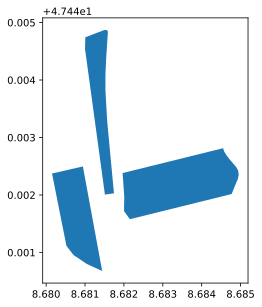

In [5]:
# Get data around SwissFutureFarm

shp = '~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/Strickhof.shp'
gdf = gpd.read_file(shp).iloc[-5:-2]

plt.style.use('default')
fig, ax = plt.subplots()
gdf.plot(ax=ax)
#cx.add_basemap(ax, crs=gdf.crs)

bounds = gdf.to_crs(32632).total_bounds
print(bounds)

# Load corresponding S2

In [6]:
# Find paths of data that falls in bounds

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    maxx = minx + 1280
    miny = maxy - 1280
    return minx, miny, maxx, maxy

# Apply the function to extract minx and maxy into new columns
df_zarr[['minx', 'miny', 'maxx', 'maxy']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))

In [7]:
# Filter for location

df_farm = df_zarr[
    (df_zarr['maxx'] >= bounds[0]) &  # The box's maxx should be greater than or equal to bbox's minx
    (df_zarr['minx'] <= bounds[2]) &  # The box's minx should be less than or equal to bbox's maxx
    (df_zarr['maxy'] >= bounds[1]) &  # The box's maxy should be greater than or equal to bbox's miny
    (df_zarr['miny'] <= bounds[3])    # The box's miny should be less than or equal to bbox's maxy
]

In [8]:
# Merge together: drop duplciate dates in each file

ds_list = [xr.open_zarr(os.path.join(data_path, f)).compute().drop_duplicates(dim='time', keep='first') for f in df_farm.file.tolist()]
ds = xr.combine_by_coords(ds_list, combine_attrs='drop')

In [9]:
# Clean data


def has_all_65535(ds):
    return ((ds == 65535).all(dim=['lat', 'lon'])).to_array().sum()

def has_clouds(ds, cloud_thresh=0.1):
    cloud_condition = (ds.s2_mask == 1) & (ds.s2_SCL.isin([8, 9, 10]))
    return cloud_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > cloud_thresh

def has_shadows(ds, shadow_thresh=0.1):
    shadow_condition = (ds.s2_mask == 2) & (ds.s2_SCL == 3)
    return shadow_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > shadow_thresh

def has_snow(ds, snow_thresh=0.1):
    snow_condition = (ds.s2_mask == 3) & (ds.s2_SCL == 11)
    return snow_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > snow_thresh

def has_cirrus(ds, cirrus_thresh=1000):
    cirrus_mask = ds.s2_SCL == 10
    cirrus_b02_mean = ds.s2_B02.where(cirrus_mask).mean(dim=['lat', 'lon'])
    return cirrus_b02_mean > cirrus_thresh

def clean_dataset(ds, cloud_thresh=0.1, shadow_thresh=0.1, snow_thresh=0.1, cirrus_thresh=1000):
  """
  Drop dates with no data and clouds/snow/shadows
  """
  n_times = len(ds.time)

  # Remove cloudy or missing dates: any of the bands is all 65535
  dates_to_drop = [i for i, date in enumerate(ds.time.values) if has_all_65535(ds.isel(time=i))]
  mask_dates = np.ones(len(ds.time), dtype=bool)
  mask_dates[dates_to_drop] = False
  ds = ds.isel(time=mask_dates)

  # Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)
  dates_to_drop = [i for i, date in enumerate(ds.time.values) if has_clouds(ds.isel(time=i), cloud_thresh)] + \
                [i for i, date in enumerate(ds.time.values) if has_shadows(ds.isel(time=i), shadow_thresh)] + \
                [i for i, date in enumerate(ds.time.values) if has_snow(ds.isel(time=i), snow_thresh)] +\
                [i for i, date in enumerate(ds.time.values) if has_cirrus(ds.isel(time=i), cirrus_thresh)]
  mask_dates = np.ones(len(ds.time), dtype=bool)
  print(f'Dropping {len(set(dates_to_drop))}/{n_times} dates') # flag if too many dates dropped?
  mask_dates[dates_to_drop] = False
  ds = ds.isel(time=mask_dates)

  return ds

In [10]:
ds = clean_dataset(ds)

Dropping 571/957 dates


In [11]:
ds

<xarray.Dataset> Size: 201MB
Dimensions:              (time: 383, lat: 128, lon: 128)
Coordinates:
  * lat                  (lat) float64 1kB 5.255e+06 5.255e+06 ... 5.254e+06
  * lon                  (lon) float64 1kB 4.751e+05 4.751e+05 ... 4.764e+05
  * time                 (time) datetime64[ns] 3kB 2017-01-27 ... 2023-12-30
Data variables: (12/21)
    mean_sensor_azimuth  (time) float32 2kB 8.374 8.355 8.353 ... 8.288 5.965
    mean_sensor_zenith   (time) float32 2kB 8.374 8.355 8.353 ... 8.288 5.965
    mean_solar_azimuth   (time) float32 2kB 67.64 61.72 58.13 ... 71.95 71.46
    mean_solar_zenith    (time) float32 2kB 67.64 61.72 58.13 ... 71.95 71.46
    product_uri          (time) <U65 100kB 'S2A_MSIL2A_20170127T102301_N0212_...
    s2_AOT               (time, lat, lon) uint16 13MB 187 187 187 ... 78 78 78
    ...                   ...
    s2_B11               (time, lat, lon) uint16 13MB 898 898 807 ... 420 420
    s2_B12               (time, lat, lon) uint16 13MB 746 746 626 ... 333 333
    s2_B8A               (time, lat, lon) uint16 13MB 3141 3141 2007 ... 448 448
    s2_SCL               (time, lat, lon) uint16 13MB 11 11 11 11 11 ... 5 5 5 5
    s2_WVP               (time, lat, lon) uint16 13MB 347 347 238 ... 205 205
    s2_mask              (time, lat, lon) uint16 13MB 0 0 0 0 0 0 ... 0 0 0 0 0

# Mask data for fields

In [12]:
nonspatial_vars = ['mean_sensor_azimuth', 'mean_sensor_zenith', 'mean_solar_azimuth', 'mean_solar_zenith', 'product_uri']
masked_mc = ds.rename({'lon': 'x', 'lat': 'y'}).rio.write_crs(32632).drop_vars(nonspatial_vars).astype(np.float32).rio.clip(gdf.to_crs(32632).geometry)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


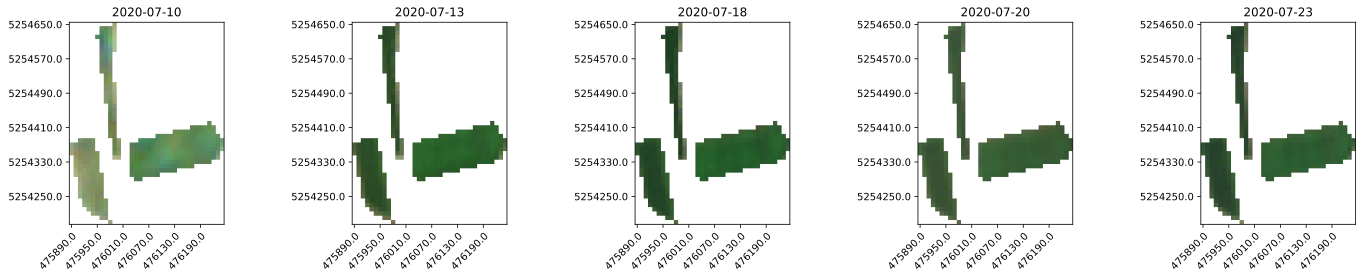

In [31]:
# Plot RGB timeseries
plt.style.use('default')
mc_timeseries = masked_mc.sel(time=slice('2020-07-09', '2020-07-30'))

mc_timeseries = mc_timeseries.where(mc_timeseries != 65535, np.nan)

scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Need to rescale each band to 0-255 and then set the nan values to 255
""" 
max_vals = rgb.max(dim=['time', 'y', 'x'])
min_vals = rgb.min(dim=['time', 'y', 'x'])
rgb_scaled = ((rgb - min_vals) / (max_vals - min_vals)) * 255.0
rgb_scaled = rgb_scaled.where(~rgb_scaled.isnull(), 0)
"""

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
brightness = 5

for i in range(5):
    axs[i].imshow(rgb[i].values * brightness, origin='upper')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    #cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    #cbar.set_label('Brightness')

plt.tight_layout()
plt.show()

# Plot predicted LAI (NN)

In [16]:
# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df = df.rename(columns={'s2_B02':"B02",'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B08":"B08", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df[df == 65535] = np.nan
df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]] = df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]/10000

In [17]:
def prepare_data(config: dict, df):
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''

  X = df[config['Data']['train_cols']]

  if config['Data']['normalize']:
    # Load scaler
    scaler_path = config['Model']['save_path'].split(f'.pkl')[0] + '_scaler.pkl'
    print(scaler_path)
    with open(scaler_path, 'rb') as f:
      scaler = pickle.load(f)
    # Normalize
    X = scaler.transform(X)
    return X
  else:
    return X


#############################################
# LOAD CONFIG

config_path = os.path.expanduser("~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/configs/config_NN.yaml")
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

if not isinstance(config['Seed'], list):
    config['Seed'] = [config['Seed']]

model_basename = os.path.join(os.path.expanduser("~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation"), config['Model']['save_path'])
gpu = config['Model'].pop('gpu')
save_model = config['Model'].pop('save') # dont need it but remove it from config

# Save preditions of each seed 
y_test_full = []
y_val_full = []

for seed in config['Seed']:
    print('Running with seed', seed)

    config['Model']['save_path'] = model_basename.split('.pkl')[0] + f'{seed}.pkl'

    #############################################
    # PREPARE DATA
    X_test = prepare_data(config=config, df=df) 

    # Move data to CUDA if GPUs requested and available
    device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'):
      X_test = torch.FloatTensor(X_test).to(device)

    #############################################
    # MODEL
    
    model_name = config['Model']['name']
    model_filename = config['Model'].pop('save_path') 
    with open(model_filename, 'rb') as f:
      model = pickle.load(f)

    if gpu and torch.cuda.is_available():
      print('Using GPUs')
      model.to(device)

    #############################################
    # TEST
  
    y_pred_test = model.predict(X_test=X_test)
    y_test_full.append(y_pred_test)

y_pred = np.mean(y_test_full, axis=0)

Running with seed 0
/home/f80873755@agsad.admin.ch/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/trained_models/NNint_soil_mult1_tuned0_scaler.pkl
Using GPUs
Running with seed 1
/home/f80873755@agsad.admin.ch/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/trained_models/NNint_soil_mult1_tuned1_scaler.pkl
Using GPUs
Running with seed 2
/home/f80873755@agsad.admin.ch/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/trained_models/NNint_soil_mult1_tuned2_scaler.pkl
Using GPUs
Running with seed 3
/home/f80873755@agsad.admin.ch/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/trained_models/NNint_soil_mult1_tuned3_scaler.pkl
Using GPUs
Running with seed 4
/home/f80873755@agsad.admin.ch/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/trained_models/NNint_soil_mult1_tuned4_scaler.pkl
Using GPUs


In [18]:
# Shape back to xarray and plot predictions

df['lai'] = y_pred.flatten()

df.set_index(['time', 'y', 'x'], inplace=True)
nn_preds = df.to_xarray()

/tmp/ipykernel_4851/4186728555.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens_cmap = cm.get_cmap('Greens')


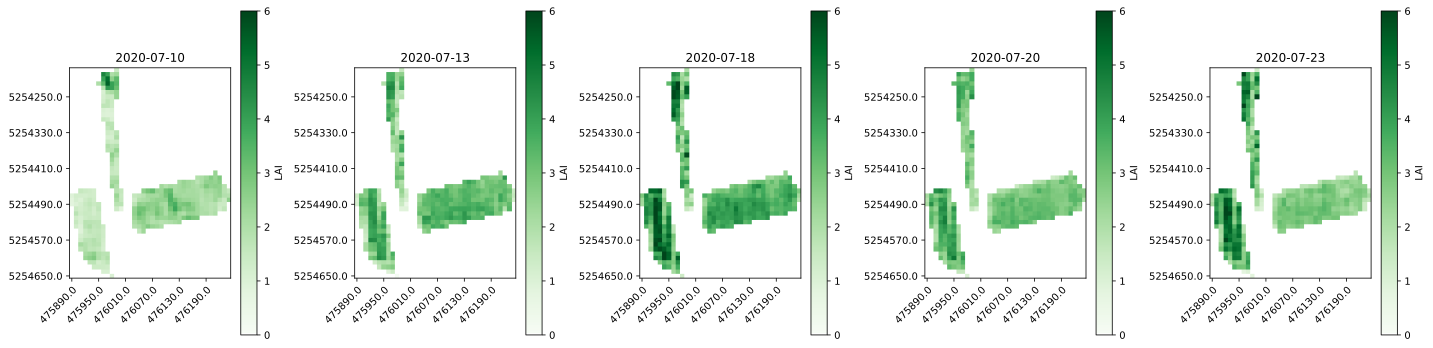

In [32]:
# Plot LAI timeseries

mc_timeseries = nn_preds.sel(time=slice('2020-07-09', '2020-07-30'))

lai = mc_timeseries['lai']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20,5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(5):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=6)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

# Plot predicted LAI (SNAP) 

In [21]:
masked_mc[['view_zenith', 'sun_zenith']] = ds.rename({'lat':'y', 'lon':'x'})[['mean_sensor_zenith', 'mean_solar_zenith']]
masked_mc['relative_azimuth'] = ds.rename({'lat':'y', 'lon':'x'})['mean_solar_azimuth'] - ds.rename({'lat':'y', 'lon':'x'})['mean_sensor_azimuth']

In [22]:
# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df = df.rename(columns={'s2_B02':"B02",'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B08":"B08", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df[df == 65535] = np.nan
df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]] = df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]/10000

In [23]:
df_lai = biophys.run_snap_biophys(df, "LAI")

In [24]:
df_lai.to_pickle('snap_lai_strickhof_small.pkl')

In [25]:
# Reshape DataFrame back to xarray format
df_lai[['time', 'y', 'x']] = df[['time', 'y', 'x']]

df_lai.set_index(['time', 'y', 'x'], inplace=True)
snap_preds = df_lai.to_xarray()

/tmp/ipykernel_4851/85612224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens_cmap = cm.get_cmap('Greens')


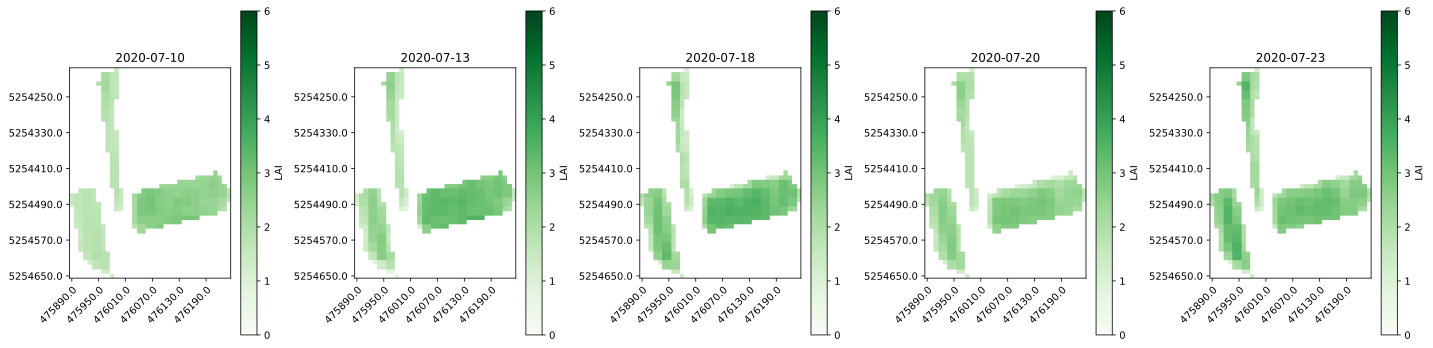

In [33]:
# Plot LAI timeseries

mc_timeseries = snap_preds.sel(time=slice('2020-07-09', '2020-07-30'))

lai = mc_timeseries['snap_LAI']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(5):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=6)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

# Final plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
import xarray as xr

/tmp/ipykernel_4851/3519670197.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens_cmap = cm.get_cmap('Greens')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/tmp/ipykernel_4851/3519670197.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


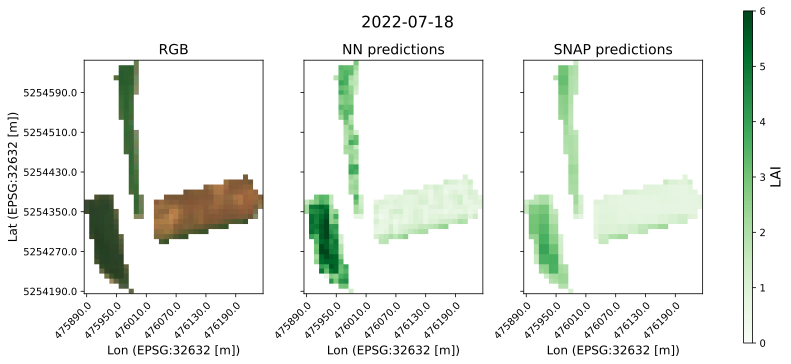

In [111]:
# RGB
time_val = '2022-07-18'
mc_timeseries = masked_mc.sel(time=time_val).isel(y=slice(None, None, -1))
mc_timeseries = mc_timeseries.where(mc_timeseries != 65535, np.nan)
scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor
rgb = xr.concat([r, g, b], dim='band').transpose('y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# NN
mc_timeseries = nn_preds.sel(time=time_val)
nn_lai = mc_timeseries['lai']
nn_lai = nn_lai.where(~np.isnan(nn_lai), other=0)

# SNAP
mc_timeseries = snap_preds.sel(time=time_val)
snap_lai = mc_timeseries['snap_LAI']
snap_lai = snap_lai.where(~np.isnan(snap_lai), other=0)

# Define the figure and GridSpec
fig = plt.figure(figsize=(12, 6))  # Adjust figure size if needed
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)  # Last one for colorbar

brightness = 5

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

# First subplot (RGB image)
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(rgb.values * brightness, origin='lower')
ax0.set_title('RGB', size=14)
ax0.set_ylabel('Lat (EPSG:32632 [m])', size=12)
ax0.set_xlabel('Lon (EPSG:32632 [m])', size=12)
ax0.set_xticks(np.arange(rgb.shape[1]))
ax0.set_yticks(np.arange(rgb.shape[0]))
ax0.set_xticklabels(rgb.coords['x'].values)
ax0.set_yticklabels(rgb.coords['y'].values)
ax0.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
ax0.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Second subplot (NN predictions)
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(nn_lai, origin='lower', cmap=custom_cmap, vmin=0, vmax=6)
ax1.set_title("NN predictions", size=14)
ax1.set_xlabel('Lon (EPSG:32632 [m])', size=12)
ax1.set_xticks(np.arange(nn_lai.shape[1]))
ax1.set_yticks(np.arange(nn_lai.shape[0]))
ax1.set_xticklabels(nn_lai.coords['x'].values)
ax1.set_yticklabels(nn_lai.coords['y'].values)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax1.get_yticklabels(), visible=False)

# Third subplot (SNAP predictions)
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(snap_lai, origin='lower', cmap=custom_cmap, vmin=0, vmax=6)
ax2.set_title("SNAP predictions", size=14)
ax2.set_xlabel('Lon (EPSG:32632 [m])', size=12)
ax2.set_xticks(np.arange(snap_lai.shape[1]))
ax2.set_yticks(np.arange(snap_lai.shape[0]))
ax2.set_xticklabels(snap_lai.coords['x'].values)
ax2.set_yticklabels(snap_lai.coords['y'].values)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax2.get_yticklabels(), visible=False)

# Colorbar for SNAP predictions
cbar_ax2 = fig.add_subplot(gs[0, 3])  # Use the same colorbar axis
cbar2 = fig.colorbar(im2, cax=cbar_ax2)
cbar2.set_label('LAI', size=14)

plt.suptitle(f'{time_val}', size=16, y=0.87)
plt.tight_layout()
plt.savefig(os.path.expanduser('~/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/RTM_emulation/notebooks/manuscript_figures/space_20220718.png'))
plt.show()


# Save as mp4

/tmp/ipykernel_1208/1098350748.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens_cmap = cm.get_cmap('Greens')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


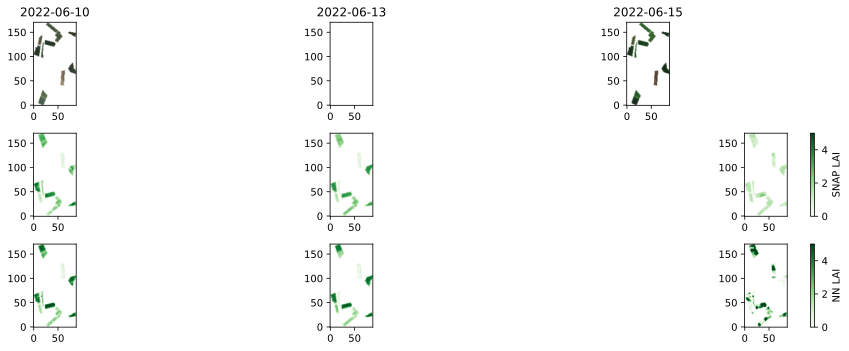

In [84]:
# Plot all timeseries

snap_timeseries = snap_preds.sel(time=slice('2022-06-10', '2022-06-30'))
rgb_timeseries = masked_mc.sel(time=slice('2022-06-10', '2022-06-30'))
nn_timeseries = nn_preds.sel(time=slice('2022-06-10', '2022-06-30'))

snap_lai = snap_timeseries['snap_LAI']
snap_lai = snap_lai.where(~np.isnan(snap_lai), other=0)
nn_lai = nn_timeseries['lai']
nn_lai = nn_lai.where(~np.isnan(nn_lai), other=0)


# Plot RGB, NN LAI and SNAP LAI for the first 5 timestamps
fig, axs = plt.subplots(3, 3, figsize=(15, 5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(3):
    im = axs[0,i].imshow(rgb[i].values*brightness, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    axs[0,i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    """
    # Set extent to match the image dimensions
    axs[0,i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[0,i].set_yticks(np.arange(rgb[i].shape[0]))
    # Set labels based on the dataset or adjust as needed
    axs[0,i].set_xticklabels(rgb[i].coords['x'].values)
    axs[0,i].set_yticklabels(rgb[i].coords['y'].values)
    # Customize tick locations and labels
    axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    # Rotate x-axis labels if needed
    plt.setp(axs[0,i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    """
    im = axs[1,i].imshow(snap_lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    """
    # Set extent to match the image dimensions
    axs[1,i].set_xticks(np.arange(snap_lai[i].shape[1]))
    axs[1,i].set_yticks(np.arange(snap_lai[i].shape[0]))
    # Set labels based on the dataset or adjust as needed
    axs[1,i].set_xticklabels(snap_lai[i].coords['x'].values)
    axs[1,i].set_yticklabels(snap_lai[i].coords['y'].values)
    # Customize tick locations and labels
    axs[1,i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[1,i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    # Rotate x-axis labels if needed
    plt.setp(axs[1,i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    """
    im = axs[2,i].imshow(nn_lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    """
    # Set extent to match the image dimensions
    axs[2,i].set_xticks(np.arange(nn_lai[i].shape[1]))
    axs[2,i].set_yticks(np.arange(nn_lai[i].shape[0]))
    # Set labels based on the dataset or adjust as needed
    axs[2,i].set_xticklabels(nn_lai[i].coords['x'].values)
    axs[2,i].set_yticklabels(nn_lai[i].coords['y'].values)
    # Customize tick locations and labels
    axs[2,i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[2,i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    # Rotate x-axis labels if needed
    plt.setp(axs[2,i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    """
# Add colorbar for each subplot
cbar = fig.colorbar(im, ax=axs[1, i], orientation='vertical')
cbar.set_label('SNAP LAI')
cbar = fig.colorbar(im, ax=axs[2, i], orientation='vertical')
cbar.set_label('NN LAI')

plt.tight_layout()
plt.show()

/tmp/ipykernel_37041/2571186754.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens_cmap = cm.get_cmap('Greens')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

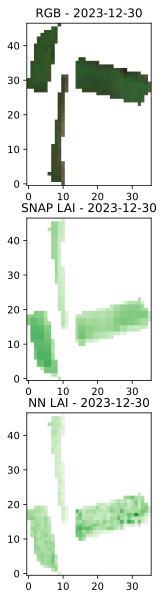

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

# Get timeseries to plot
snap_lai = snap_preds['snap_LAI']
snap_lai = snap_lai.where(~np.isnan(snap_lai), other=0)
nn_lai = nn_preds['lai']
nn_lai = nn_lai.where(~np.isnan(nn_lai), other=0)

mc_timeseries = masked_mc.where(masked_mc != 65535, np.nan)
scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)


# Set up the figure and axis
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# Initialize images
im_rgb = axs[0].imshow(rgb.isel(time=0).values*5, origin='upper')
im_snap = axs[1].imshow(snap_lai.isel(time=0).values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
im_nn = axs[2].imshow(nn_lai.isel(time=0).values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)

# Set titles and axis labels
axs[0].set_title('RGB')
axs[1].set_title('SNAP LAI')
axs[2].set_title('NN LAI')

# Function to update the frame
def update(frame):
    # Update images for the current timestamp
    im_rgb.set_array(rgb.isel(time=frame).values*5)
    im_snap.set_array(snap_lai.isel(time=frame).values)
    im_nn.set_array(nn_lai.isel(time=frame).values)
    
    # Update title with the current timestamp
    date_str = str(rgb.time.values[frame]).split('T')[0]
    axs[0].set_title(f"RGB - {str(rgb.time.values[frame]).split('T')[0]}")
    axs[1].set_title(f"SNAP LAI - {str(snap_lai.time.values[frame]).split('T')[0]}")
    axs[2].set_title(f"NN LAI - {str(nn_lai.time.values[frame]).split('T')[0]}")
    
    return im_rgb, im_snap, im_nn

# Create the animation
ani = FuncAnimation(fig, update, frames=len(rgb.time), blit=True)

# Save the animation as an MP4 video using ffmpeg
ani.save('strickhof.mp4', writer='ffmpeg', fps=1)  # Adjust fps (frames per second) as needed
